In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import gensim
from gensim.models import Word2Vec

# Narrative - Exploratory Data Analysis

Exploratory data analysis of APHIS inspection reports data's "narrative" column. 

In [2]:
combined_dir = './aphis-inspection-reports/data/combined/'

In [3]:
narratives = pd.read_csv(combined_dir + 'inspections-narratives.csv')
print(narratives.shape)
narratives.columns.tolist()

(94753, 2)


['hash_id', 'narrative']

In [4]:
species = pd.read_csv(combined_dir + 'inspections-species.csv')
print(species.shape)
species.columns.tolist()

(397371, 4)


['hash_id', 'count', 'scientific', 'common']

In [5]:
citations = pd.read_csv(combined_dir + 'inspections-citations.csv')
print(citations.shape)
citations.columns.tolist()

(38684, 6)


['hash_id', 'code', 'kind', 'repeat', 'desc', 'narrative']

In [6]:
inspections = pd.read_csv(combined_dir + 'inspections.csv')
print(inspections.shape)
inspections.columns.tolist()

(95328, 31)


/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/2060818130.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  inspections = pd.read_csv(combined_dir + 'inspections.csv')


['web_certNumber',
 'web_certType',
 'web_city',
 'web_critical',
 'web_customerNumber',
 'web_direct',
 'web_inspectionDate',
 'web_legalName',
 'web_nonCritical',
 'web_reportLink',
 'web_siteName',
 'web_state',
 'web_teachableMoments',
 'web_zip',
 'hash_id',
 'discovered',
 'pdf_insp_id',
 'pdf_layout',
 'pdf_customer_id',
 'pdf_customer_name',
 'pdf_customer_addr',
 'pdf_certificate',
 'pdf_site_id',
 'pdf_site_name',
 'pdf_insp_type',
 'pdf_date',
 'pdf_report_date',
 'pdf_animals_total',
 'doccloud_url',
 'licenseType',
 'customer_state']

In [7]:
# Joining inspections and citations 
inspections_citations = inspections.merge(citations, how='left', on='hash_id')
inspections_citations = inspections_citations.drop_duplicates(subset=['hash_id'])
inspections_citations.shape

(94725, 36)

In [8]:
# Overview of all column values
for i in inspections_citations.columns.tolist(): 
    print(inspections_citations[i].value_counts())
    print('------------------------')
    print()

web_certNumber
33-T-0011    473
57-T-0001    451
74-T-0007    438
87-T-0003    292
91-T-0001    251
            ... 
71-C-0117      1
74-B-0796      1
21-T-0090      1
63-A-0180      1
33-A-0628      1
Name: count, Length: 14073, dtype: int64
------------------------

web_certType
Class A - Breeder                               32589
Class C - Exhibitor                             31431
Class R - Research Facility                     12429
Class B - Dealer                                10016
Class T - Carrier                                5845
Class H - Intermediate Handler                   1142
Class G - Agricultural Research Facility ARS      357
Class F - Federal Research Facility                38
Class E - Exhibitor                                 1
Class V - Veteran's Administration Hospital         1
Name: count, dtype: int64
------------------------

web_city
MILLERSBURG           876
CHICAGO               712
SAN FRANCISCO         613
MONTGOMERY            520
LAS VEGAS    

doccloud_url
https://www.documentcloud.org/documents/23470070-aphis-inspection-134152009280944     1
https://www.documentcloud.org/documents/23529774-aphis-inspection-182141141560226     1
https://www.documentcloud.org/documents/23529783-aphis-inspection-2016082568106379    1
https://www.documentcloud.org/documents/23529782-aphis-inspection-217161023290063     1
https://www.documentcloud.org/documents/23529781-aphis-inspection-61161819250463      1
                                                                                     ..
https://www.documentcloud.org/documents/23499568-aphis-inspection-288151234590879     1
https://www.documentcloud.org/documents/23499567-aphis-inspection-272141026528216     1
https://www.documentcloud.org/documents/23499566-aphis-inspection-174141057436858     1
https://www.documentcloud.org/documents/23499565-aphis-inspection-85141553133977      1
https://www.documentcloud.org/documents/23700150-aphis-inspection-ins-0000840089      1
Name: count, Length

In [9]:
inspections_citations['narrative'].notnull().sum()

21042

In [10]:
inspections_citations[inspections_citations['narrative'].notnull()]['pdf_insp_type'].value_counts()

pdf_insp_type
ROUTINE INSPECTION       13205
ATTEMPTED INSPECTION      6721
FOCUSED INSPECTION         659
RE-LICENSE INSPECTION      416
NEW SITE INSPECTION         41
Name: count, dtype: int64

In [11]:
# web_critical = Number of "critical" noncompliant items
inspections_citations[inspections_citations['narrative'].notnull()]['web_critical'].value_counts()

web_critical
0    19673
1     1144
2      161
3       44
4       14
5        4
6        1
8        1
Name: count, dtype: int64

In [12]:
# web_direct = Number of "direct" noncompliant items
inspections_citations[inspections_citations['narrative'].notnull()]['web_direct'].value_counts()

web_direct
0     19668
1      1038
2       216
3        61
4        30
5        16
7         4
6         4
8         3
9         1
14        1
Name: count, dtype: int64

In [13]:
inspections_citations[(inspections_citations['narrative'].notnull()) & (inspections_citations['web_direct']== 0)]['narrative'].tolist()

['At the south farm, a goat was observed to jump up onto the ledge of the concrete foundation and move from pen 4\nover to pen 5 and then back to pen 4 again. There was a panel up on the ledge in place to prevent this, however\nthe goat could pass between the vertical supports of the panel. Also, the panel had some free ends of wire that if\nbent out could become sharp points exposed to any goat that climbs up on the concrete ledge. Lack of proper\ncontainment and exposure to sharp points could lead to injury or other adverse events. The facility must ensure\nthat enclosures are structurally sound and maintained in good repair to contain the animals and protect them from\ninjury.\nCorrect by October 5, 2016.\nThis inspection and exit interview were conducted with facility representatives on 9/26 thru 9/27/2016.',
 'Two bottles of Heparin (one partially used, one unopened) and one partially used tube of Puralube eye lubrication\nointment were found in room 140 at ATRC building that were

## Word Frequencies

Looking at most frequently occuring words in "narrative" column. 

In [14]:
inspections_citations_notnull = inspections_citations[inspections_citations['narrative'].notnull()]

In [15]:
# Load NLTK stopwords
stop_words = set(stopwords.words("english"))

# Combine all text from the 'text_column' into a single string
all_text = ' '.join(inspections_citations_notnull['narrative'].apply(lambda x: x.lower()))

# Tokenize the combined text
tokens = word_tokenize(all_text)

# Remove stopwords
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_tokens)

# Get the most common words
most_common_words = word_counts.most_common()

print("Most Frequent Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Frequent Words:
.: 124615
,: 75584
inspection: 26163
animals: 20027
facility: 18958
licensee: 16366
must: 15003
*: 14124
animal: 13565
): 12974
(: 12668
available: 11935
care: 11337
veterinarian: 11133
adult: 10340
aphis: 9433
veterinary: 8997
conducted: 8453
enclosure: 8137
officials: 8103
responsible: 8078
correct: 7903
accompany: 7785
:: 7769
process: 7733
exit: 7276
ensure: 6665
attending: 6421
dogs: 6337
records: 5965
one: 5577
health: 5532
dog: 5524
program: 5456
inspector: 5429
interview: 5198
enclosures: 5187
section: 5126
time: 5105
shall: 4908
left: 4870
treatment: 4713
corrected: 4681
may: 4483
two: 4035
could: 3973
's: 3895
representative: 3768
area: 3695
#: 3691
contact: 3622
injury: 3594
stated: 3582
appropriate: 3420
number: 3412
inspectors: 3317
end: 3307
female: 3270
housing: 3234
use: 3158
iacuc: 3150
also: 3113
plan: 3097
additional: 3057
hair: 3053
required: 3040
medical: 3033
prevent: 3017
written: 2999
eye: 2897
fence: 2893
adequate: 2883
provided: 2794
pm: 2

## TFIDF

Looking at most important words in "narrative" column based on term frequency–inverse document frequency (a measure of importance of a word to a collection of documents, adjusted for the fact that some words appear more frequently in general).  

In [16]:
# Function to get the most frequent words and their TF-IDF scores
def get_top_words_tfidf(text_column, max_features=10):
    # Count Vectorizer
    count_vectorizer = CountVectorizer(stop_words='english')
    count_matrix = count_vectorizer.fit_transform(text_column)

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_column)

    # Get feature names
    feature_names = count_vectorizer.get_feature_names_out()

    # Calculate TF-IDF scores
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    # Create a DataFrame with words and their TF-IDF scores
    tfidf_df = pd.DataFrame({'Word': feature_names, 'TFIDF Score': tfidf_scores})

    # Sort DataFrame by TF-IDF Score in descending order
    tfidf_df = tfidf_df.sort_values(by='TFIDF Score', ascending=False)

    # Get the top words
    top_words = tfidf_df#.head(max_features)

    return top_words

In [17]:
# Get the top words and their TF-IDF scores
top_words_tfidf = get_top_words_tfidf(inspections_citations_notnull['narrative'])
top_words_tfidf['rank'] = np.arange(1, top_words_tfidf.shape[0]+1, 1)

In [18]:
top_words_tfidf.head(20)

,Word,TFIDF Score,rank
12823,inspection,1145.569878,1
5654,available,1042.904557,2
4585,accompany,894.491386,3
18356,responsible,894.471091,4
5265,aphis,875.369269,5
4788,adult,867.847376,6
17238,process,857.211842,7
15735,officials,855.031891,8
10517,facility,770.885502,9
13930,licensee,754.874522,10


In [19]:
porter_stemmer = PorterStemmer()

def stem_text(text):
    # Tokenize the text and apply stemming to each token
    tokens = word_tokenize(text)
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Apply stemming to the text column
inspections_citations_notnull['stemmed_narrative'] = inspections_citations_notnull['narrative'].apply(stem_text)

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/3917990956.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspections_citations_notnull['stemmed_narrative'] = inspections_citations_notnull['narrative'].apply(stem_text)


In [20]:
# Get the top words of stemmed_narrative and their TF-IDF scores
top_stemmed_words_tfidf = get_top_words_tfidf(inspections_citations_notnull['stemmed_narrative'])

In [21]:
top_stemmed_words_tfidf['rank'] = np.arange(1, top_stemmed_words_tfidf.shape[0]+1, 1)
top_stemmed_words_tfidf.head(20)

,Word,TFIDF Score,rank
17277,wa,1263.530073,1
10323,inspect,1203.900504,2
5257,avail,1080.122253,3
4925,anim,1034.124336,4
14346,respons,927.865807,5
4535,accompani,904.056392,6
12588,offici,889.390761,7
5016,aphi,888.318447,8
4658,adult,883.758136,9
8079,dure,879.083789,10


In [22]:
top_words_tfidf[top_words_tfidf['Word'] == 'heat']

,Word,TFIDF Score,rank
11952,heat,24.72584,937


In [23]:
top_words_tfidf[top_words_tfidf['Word'] == 'temperature']

,Word,TFIDF Score,rank
20928,temperature,55.97741,453


In [24]:
top_stemmed_words_tfidf[top_stemmed_words_tfidf['Word'] == 'heat']

,Word,TFIDF Score,rank
9718,heat,32.189505,713


In [25]:
top_stemmed_words_tfidf[top_stemmed_words_tfidf['Word'] == 'temperature']

,Word,TFIDF Score,rank
16152,temperature,0.351561,8543


## Topic Modeling

Using topic modeling as an EDA tool. By clustering narratives by topic, we can see if any obvious/useful categories emerge. Listed below are new themes that emerged with increased clusters. 

### Narrative Themes

##### 10 Clusters
- Expired medications
- Visible wounds/hair loss/sickness
- Mention of "A responsible adult was not available to accompany APHIS officials during inspection"
    - Can be filtered out with pdf_insp_type == 'ATTEMPTED INSPECTION'
- Mention of "IACUC" (Institutional Animal Care and Use Committee)
- Flaws in animal enclosures/physical environment
- A written program of veterinary care is absent/outdated/incomplete
- Importation/transportation of animals (especially by plane)

##### 15 Clusters
- Accumulation of filth; need for sanitation/disinfectant
- Unauthorized sale/exhibition of animals

##### 20 Clusters
- Failures in storage (e.g. bedding, food)
- Incomplete inventory/records of animals

In [26]:
def plot_kcluster_elbow(word_list):
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(word_list)

    # Experiment with a range of clusters
    max_clusters = 10
    distortions = []

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

def show_kclusters(word_list, optimal_clusters):
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(word_list)

    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans.fit(X)

    word_list_clusters = list(zip(word_list, kmeans.labels_))

    for cluster_id in range(optimal_clusters):
        cluster_words = [word for word, label in word_list_clusters if label == cluster_id]
        print(f"Cluster {cluster_id + 1}: {cluster_words}")
        print()

def topic_modeling(df, text_column, num_topics):
    # Create a pipeline for topic modeling
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lda', LatentDirichletAllocation(n_components=num_topics, random_state=42))
    ])

    # Fit the pipeline on the text column
    df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)

    return df

/Users/kchua/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kchua/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


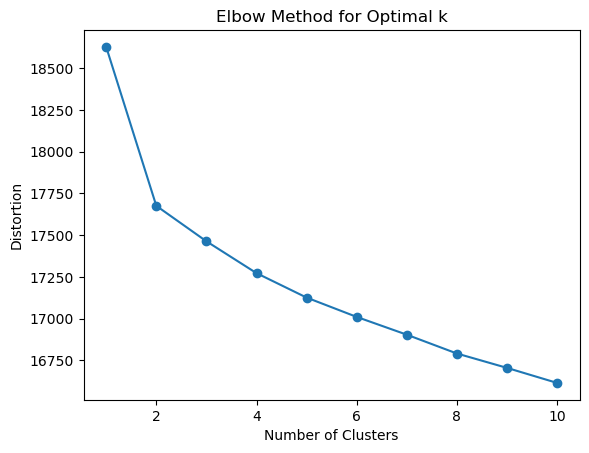

In [27]:
unique_vals = inspections_citations_notnull['narrative'].unique()
plot_kcluster_elbow(unique_vals)

In [28]:
# Using topic modeling as EDA tool
df = topic_modeling(inspections_citations_notnull, text_column='narrative', num_topics=10)

for cluster_id in df['topic_cluster'].unique():
    cluster_rows = df[df['topic_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_rows['narrative'])
    print()

Cluster 1:
2         At the south farm, a goat was observed to jump...
40        According to facility observational and/or hea...
49        Two marmosets (male 601 858 271, female 844 82...
88        The bales of hay being fed to 66 ewes and 65 l...
92        In the enclosure housing 8 sheep at the Multip...
                                ...                        
112744    The outdoor enclosure housing two adult common...
112748    On November 2nd, 2023 a young child was bitten...
112805    A member of the public was bitten by an Africa...
112840    Per the licensee, on 10/16/2023 a 3 month old ...
112854    A section of chicken wire attached to the goat...
Name: narrative, Length: 5515, dtype: object

Cluster 9:
4         Two bottles of Heparin (one partially used, on...
34        One expired bottle of Isoflourane (expiration ...
73        **Several expired medications were found in th...
89        ***Facility personnel did not perform adequate...
96        On August 6, 2021, fac

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [29]:
#df['topic_cluster'].value_counts()

In [30]:
# Repeating with higher maximum clusters to extract additional obvious groups
df = topic_modeling(inspections_citations_notnull, text_column='narrative', num_topics=15)

# Print clusters
for cluster_id in df['topic_cluster'].unique():
    cluster_rows = df[df['topic_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_rows['narrative'])
    print()

Cluster 1:
2         At the south farm, a goat was observed to jump...
40        According to facility observational and/or hea...
49        Two marmosets (male 601 858 271, female 844 82...
88        The bales of hay being fed to 66 ewes and 65 l...
92        In the enclosure housing 8 sheep at the Multip...
                                ...                        
112744    The outdoor enclosure housing two adult common...
112748    On November 2nd, 2023 a young child was bitten...
112805    A member of the public was bitten by an Africa...
112840    Per the licensee, on 10/16/2023 a 3 month old ...
112854    A section of chicken wire attached to the goat...
Name: narrative, Length: 5504, dtype: object

Cluster 9:
4         Two bottles of Heparin (one partially used, on...
34        One expired bottle of Isoflourane (expiration ...
42        In August 2015, a cynomolgus macaque placed un...
44        A review of facility records for the marmoset ...
47        A protocol involving s

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [31]:
#df['topic_cluster'].value_counts()

In [32]:
#df[df['topic_cluster'] == 14]['narrative'].tolist()

In [33]:
# Repeating with higher maximum clusters to extract additional obvious groups
df = topic_modeling(inspections_citations_notnull, text_column='narrative', num_topics=20)

# Print clusters
for cluster_id in df['topic_cluster'].unique():
    cluster_rows = df[df['topic_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_rows['narrative'])
    print()

Cluster 18:
2         At the south farm, a goat was observed to jump...
40        According to facility observational and/or hea...
92        In the enclosure housing 8 sheep at the Multip...
143       The facility is comprised of enclosures and a ...
409       Multiple small areas areas associated with sea...
                                ...                        
112265    The current large outdoor pen has two large ho...
112505    * The welded wire fencing in one enclosure has...
112562    A 3-week old Teddy was observed to be sticking...
112744    The outdoor enclosure housing two adult common...
112854    A section of chicken wire attached to the goat...
Name: narrative, Length: 1778, dtype: object

Cluster 9:
4         Two bottles of Heparin (one partially used, on...
34        One expired bottle of Isoflourane (expiration ...
73        **Several expired medications were found in th...
89        ***Facility personnel did not perform adequate...
101       Several expired or im

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [34]:
#df['topic_cluster'].value_counts()

In [35]:
#df[df['topic_cluster'] == 13]['narrative'].tolist()

## Heat/Temperature

Exploratory data analysis for specifically heat/temperature. 

### Notes 

- At 419 narratives, the heat/temperature flag has just 2% coverage of total narratives
    - TFIDF values for heat and temperature are also low, not in top ~300 terms <br><br>

- Mention of “heat” does not always mean the inspection revealed the animal was subject to overheating/excessive cooling.
    - Why? “Overheating” or "heat" is often a sub-item in a standardized list of ways an animal should not be treated. The sentiment roughly reads (the exact phrasing changes; possibly a sentence included in some guiding inspection document): “all handling of animals should be done as carefully as possible in a manner that does not cause **overheating**, physical harm, or unnecessary discomfort.”
        - 144 narratives contain the substring “carefully as possible in a manner that does not cause” (likely an undercount of the sub-item phenomenon)
    - Additionally, heat/temperature can also be used to describe an outcome to prevent, for example: "... repair the electrical outlet and then determine the capability of the unit to insure in can store food at the proper **temperature** and humidity."<br><br>

- Filtering narratives according to mention of heat/temperature still results in diverse inspection findings/recommendations
     - Animals suffered from overheating 
         - E.g. "The initial corrective action was insufficient to maintain the appropriate temperature\nfor hamsters, leading to an ambient temperature of >85 degrees for more than 12 hour" 
        - "On May 2, 2022, four Damaraland mole rats were found dead in their enclosures. According to facility personnel, an\nelectric space heater that was being used to provide supplemental heat for the animals was somehow placed under the\nmetal rack holding the enclosures resulting in the animals overheating."
    - Improper sanitization procedures
        - "The facility could not verify that the Guinea Pig primary enclosures are being adequately sanitized. The facility currently\nuses temperature-tapes to verify that the correct temperature (180 degrees Fahrenheit) is reached by the automated\nwashing systems. There have been numerous failures of this system to reach the required temperatures and numerous\nadditional weeks where the staff has failed to follow their internal procedures to test the temperatures in order to verify\nthat the washing system is functioning properly.\nTemperature tape readings record whether the cage wash reaches the required 180 degrees."
    
### Questions
- What is the purpose behind identifying narratives involving heat/temperature?
    - A frequently occuring inspection theme is flaws in animals' enclosures. Inadequate enclosures can lead to animal overheating/underheating. Should the flag focus on the outcome (overheating/underheating) or the initial failure in enclosure maintenance/construction?
- What are more useful flags for assisting future analysis of this dataset? 
- Should flags aim for broadness/coverage? Or should flags identify very specific/rare phenomenons?

In [36]:
df['narrative'].notnull().sum()

21042

In [37]:
print(len(df[df['narrative'].str.contains('heat | temperature')]['narrative'].tolist()))

423


In [38]:
419/20842 * 100

2.0103636887054988

In [39]:
df[df['narrative'].str.contains('heat | temperature')]['narrative'].tolist()

["In August 2015, a cynomolgus macaque placed under anesthesia for a study procedure was observed to have a\nlow body temperature. In order to normalize the animal's core temperature during the procedure, a staff member\nwas directed by a veterinarian to use a hot air source; however, the nozzle of this hot air source was inappropriately\nplaced in a location which subsequently led to thermal injuries and later, euthanasia.\nIt is the responsibility of the research facility to ensure that all scientists, research technicians, animal technicians,\nand other personnel involved in animal care, treatment, and use are qualified to perform necessary or directed\nduties. This responsibility shall be fulfilled in part through the provision of training and appropriate instruction to\nthose personnel.\nCorrective measures were taken, including but not limited to, retraining of all involved staff and observation of\ntechniques by veterinary staff.\nThis item has been corrected by the facility.",


In [40]:
#df['narrative_no_nums'] = df['narrative'].str.replace(r'\d+', '', regex=True)
#df[df['narrative_no_nums'].str.contains('2')]['narrative_no_nums']

# Tokenize the text in the 'text' column
df['tokenized_text'] = df['narrative'].apply(lambda x: word_tokenize(x.lower()))

# Train Word2Vec model
model = Word2Vec(sentences=df['tokenized_text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/3606272378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['narrative'].apply(lambda x: word_tokenize(x.lower()))


In [41]:
# Find words related to "heat" or "temperature" or "hot"
similar_heat = model.wv.most_similar('heat', topn=50)
similar_temperature = model.wv.most_similar('temperature', topn=50)
similar_hot = model.wv.most_similar('hot', topn=50)

In [42]:
print("Words related to 'hot':", [word for word, score in similar_hot])

Words related to 'hot': ['strands', 'twine', 'chicken', 'frozen', 'larger', 'baling', 'poles', 'ice', 'too', 'breaking', 'buckets', 'torn', '3.5', 'bulbs', 'cloth', 'saturated', 'block', 'rotting', 'connected', 'exposing', 'bucket', 'insulated', 'unprotected', 'leaning', 'barrel', 'soft', 'low', '180', 'loose', 'hardware', 'shredded', 'sweet', 'coated', 'nipples', 'meat', 'deep', 'outward', 'actively', 'tub', 'gets', 'tie', 'lamps', 'fresh', 'bent', 'buried', 'muddy', 'drain', 'warped', 'badly', 'stream']


In [43]:
print("Words related to 'heat':", [word for word, score in similar_heat])

Words related to 'heat': ['cold', 'weather', 'rain', 'lamps', 'wind', 'inclement', 'protection', 'exposure', 'extreme', 'extremes', 'temperatures', 'breaks', 'lamp', 'ventilation', 'comfortably', 'snow', 'shelter', 'sun', 'cool', 'calories', 'levels', 'artificial', 'cooling', 'ambient', 'break', 'handholds', 'sunlight', 'overheating', 'climbing', 'elements', 'environments', 'injuring', 'shade', 'obstruction', 'deterioration', 'relief', 'wind/rain', 'spoilage', 'temperature', 'warm', 'rate', 'chills', 'separation', 'blowing', 'freezing', 'becoming', 'tripping', 'unprotected', 'lids', 'entrances']


In [44]:
print("Words related to 'temperature':", [word for word, score in similar_temperature])

Words related to 'temperature': ['ambient', 'temperatures', 'degrees', 'humidity', 'f.', 'fahrenheit', '85', 'exceed', '76.5', '98.5', 'extremes', 'low', 'cold', '50', 'predicted', 'f', 'weather', 'ventilation', 'heat', 'heater', 'levels', '60', '94', '98.4', 'air', '89.8', 'range', 'deg', 'cooled', '36-46', 'kestrel', 'heated', 'below', '35', '85°', '47.5', '89.4', '54.7', '88.0', 'rise', '35f', '91', 'tonight', 'night', '41°', '75-101', 'bedding', '52.3', 'misters', '91.8']


### Heat/Temperature Topic Modeling

In [45]:
# Topic modeling for just narratives containing heat, temperature

# Placeholder temperature/heat keywords
temp_keywords = ['heat', 'temperature', 'humid', 'cold', 'weather', 'wind', 'rain', 'inclement', 'extremes', 'hypothermia', 
                'cooling', 'freezing', 'ambient', 'chill', 'fahrenheit', 'degrees', 'weather', 'inclement']

In [46]:
# Create flag column
inspections_citations_notnull['heat_temp_flag'] = citations['narrative'].apply(lambda x: any(word in x.lower() for word in temp_keywords))

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/3886875396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspections_citations_notnull['heat_temp_flag'] = citations['narrative'].apply(lambda x: any(word in x.lower() for word in temp_keywords))


In [47]:
inspections_citations_notnull['heat_temp_flag'].value_counts(normalize=True)

heat_temp_flag
False    0.870205
True     0.129795
Name: proportion, dtype: float64

In [48]:
heat_temp_narratives = inspections_citations_notnull[inspections_citations_notnull['heat_temp_flag'] == True]

In [49]:
# Using topic modeling as EDA tool
df = topic_modeling(heat_temp_narratives, text_column='narrative', num_topics=10)

for cluster_id in df['topic_cluster'].unique():
    cluster_rows = df[df['topic_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_rows['narrative'])
    print()

Cluster 5:
4        Two bottles of Heparin (one partially used, on...
42       In August 2015, a cynomolgus macaque placed un...
86       Two IACUC approved protocols did not have an a...
89       ***Facility personnel did not perform adequate...
96       On August 6, 2021, facility staff discovered e...
                               ...                        
38417    ****The lion exhibit had chicken left overs mo...
38418    The floor on the primate enclosures had algae ...
38508    *** In the first wolf enclosure, containing tw...
38589    On Tuesday August 19th, 2014 two inspectors fr...
38608    During the exit interview of this inspection t...
Name: narrative, Length: 709, dtype: object

Cluster 9:
206      A responsible adult was not available to accom...
259      There was no one available during business hou...
937      A responsible adult was not available to accom...
1334     There was no one available during business hou...
1338     There was no one available during busin

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [50]:
df['topic_cluster'].value_counts()

topic_cluster
5    709
9    191
Name: count, dtype: int64

In [51]:
df[df['topic_cluster'] == 5]['narrative'].tolist()

['Two bottles of Heparin (one partially used, one unopened) and one partially used tube of Puralube eye lubrication\nointment were found in room 140 at ATRC building that were expired (06/2017 and 05/2016 respectively). In the\nrefrigerator in the Stallion Barn lab area, a syringe containing a white liquid was unlabeled and undated. Liquids in\nunlabeled syringes are not identifiable and may be incorrectly administrated or improperly used. Expired\nmedications may have compromised efficacy and potency. Use of unlabeled medication or expired drugs may be\nharmful or lead to untowards effects or inadequate treatment. The facility needs to ensure that medications are\nstored and labeled properly and are not being used past their expiration date. Corrected at time of inspection.\nThis inspection and exit interview were conducted with facility representatives.\nAdditional Inspectors\nSecor Thomas, Veterinary Medical Officer',
 "In August 2015, a cynomolgus macaque placed under anesthesia fo

### Filtering for Critical and Direct Citations

In [60]:
df['kind'].value_counts(dropna=False)

kind
NaN         802
Critical     54
Direct       44
Name: count, dtype: int64

In [61]:
# Web critical: 111 total
df['web_critical'].value_counts(dropna=False)

web_critical
0    789
1     88
2     16
3      6
5      1
Name: count, dtype: int64

In [62]:
# Web direct: 61 total
df['web_direct'].value_counts(dropna=False)

web_direct
0    839
1     47
3      5
2      4
4      4
6      1
Name: count, dtype: int64

In [59]:
df['pdf_insp_type'].value_counts(dropna=False)

pdf_insp_type
ROUTINE INSPECTION       640
ATTEMPTED INSPECTION     196
FOCUSED INSPECTION        43
RE-LICENSE INSPECTION     20
NEW SITE INSPECTION        1
Name: count, dtype: int64

In [57]:
df[df['topic_cluster'] == 9]['pdf_insp_type'].value_counts(dropna=False)

pdf_insp_type
ATTEMPTED INSPECTION    191
Name: count, dtype: int64

In [67]:
critical_direct_narratives = inspections_citations_notnull[(inspections_citations_notnull['kind'].isin(['Critical', 'Direct']) |
                                                            (inspections_citations_notnull['web_direct'] != 0) |
                                                            (inspections_citations_notnull['web_critical'] != 0))]

In [70]:
critical_direct_narratives['kind'].value_counts()

kind
Direct      1000
Critical     709
Name: count, dtype: int64

In [72]:
critical_direct_narratives['web_critical'].value_counts()

web_critical
0    1233
1    1144
2     161
3      44
4      14
5       4
6       1
8       1
Name: count, dtype: int64

In [76]:
# Using topic modeling as EDA tool
df = topic_modeling(critical_direct_narratives, text_column='narrative', num_topics=10)

for cluster_id in df['topic_cluster'].unique():
    cluster_rows = df[df['topic_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_rows['narrative'])
    print()

Cluster 9:
40        According to facility observational and/or hea...
44        A review of facility records for the marmoset ...
89        ***Facility personnel did not perform adequate...
101       Several expired or improperly labeled medicati...
130       A ram at a sheep flock that is used under a ho...
                                ...                        
112414    Several dogs didn’t have water available at th...
112586    The facility has been conducting regulated act...
112594    The certifications of the last offering of foo...
112599    The certifications of the last offering of foo...
112840    Per the licensee, on 10/16/2023 a 3 month old ...
Name: narrative, Length: 2333, dtype: object

Cluster 3:
42        In August 2015, a cynomolgus macaque placed un...
49        Two marmosets (male 601 858 271, female 844 82...
96        On August 6, 2021, facility staff discovered e...
483       On June 16th 2021, a rhesus macaque was found ...
485       On July 30th, 2021 ten

/var/folders/7b/llw41rn55vn8yn15rg03bjxh0000gn/T/ipykernel_75775/2398067158.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_cluster'] = pipeline.fit_transform(df[text_column]).argmax(axis=1)


In [74]:
df[df['topic_cluster'] == 3]['narrative'].tolist()

["In August 2015, a cynomolgus macaque placed under anesthesia for a study procedure was observed to have a\nlow body temperature. In order to normalize the animal's core temperature during the procedure, a staff member\nwas directed by a veterinarian to use a hot air source; however, the nozzle of this hot air source was inappropriately\nplaced in a location which subsequently led to thermal injuries and later, euthanasia.\nIt is the responsibility of the research facility to ensure that all scientists, research technicians, animal technicians,\nand other personnel involved in animal care, treatment, and use are qualified to perform necessary or directed\nduties. This responsibility shall be fulfilled in part through the provision of training and appropriate instruction to\nthose personnel.\nCorrective measures were taken, including but not limited to, retraining of all involved staff and observation of\ntechniques by veterinary staff.\nThis item has been corrected by the facility.",
